In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from itertools import product
import calendar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.api.types import CategoricalDtype

plt.style.use('seaborn')

In [3]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, f1_score

In [4]:
from model.helpers.ts_differencing import *
from model.model_training import train_model, train_test_split_ts

<a id='wrangling'></a>
## Data Wrangling

Check ../Bitcoin Data Wrangling.ipynb

<a id='gather'></a>
### Gather

In [5]:
df = pd.read_csv('../data/bitcoin_data.csv', parse_dates=[0], index_col=[0])

In [6]:
df.head()

,currency,open,high,low,close,volume,market_cap
Date,,,,,,,
2013-04-28,bitcoin,135.30,135.98,132.10,134.21,NaN,1.488567e+09
2013-04-29,bitcoin,134.44,147.49,134.00,144.54,NaN,1.603769e+09
2013-04-30,bitcoin,144.00,146.93,134.05,139.00,NaN,1.542813e+09
2013-05-01,bitcoin,139.00,139.89,107.72,116.99,NaN,1.298955e+09
2013-05-02,bitcoin,116.38,125.60,92.28,105.21,NaN,1.168517e+09


<a id='helper_classes'></a>
## Helper Classes & Methods

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['{}_(t-{})'.format(var_name, i) for var_name in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['{}'.format(var_name) for var_name in data.columns]
        else:
            names += ['{}_(t+{})'.format(var_name, i) for var_name in data.columns]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
def feature_mapping(x, order, intercept=False, only_self_terms=False):
    """
    Maps the original features up to the chosen degree.
    Example for initial features a and b and chosen order of 3:
    [a b a^2 ab b^2 a^3 a^2b ab^2 b^3]
    :param x: array like object of m examples by n features
    :param order: order of the polynomial expansion mapping to perform
    :param intercept: If return array should include the intercept column
    :param only_self_terms: if should only include polynomial terms (eg: x, x2, x3, etc)
    :return: array with mapped features
    """
    X = np.array(x).copy()

    n_features = X.shape[1] if len(X.shape) > 1 else 1
    features = [i for i in range(n_features)]

    for i in range(2, order + 1):

        if only_self_terms:

            for j in features:
                # X = np.hstack((X, X[:, j] ** i))
                X = np.c_[X, X[:, j] ** i]

        else:
            product_cases = list(product(features, repeat=i))

            product_cases = [tuple(sorted(t)) for t in product_cases]
            product_cases = list(set(product_cases))

            for case in product_cases:

                columns = np.array([x[:, int(col)] for col in case]).T
                columns_prod = np.cumprod(columns, axis=1)[:, -1].reshape(-1, 1)

                X = np.hstack((X, columns_prod))

    if intercept:
        X = np.c_[np.ones(X.shape[0]), X]

    return X

In [9]:
def plot_learning_curve(estimator, title, X, y, 
                        axes=None, ylim=None, cv=None,
                        n_jobs=-1, 
                        train_sizes=np.linspace(0.1, 1.0, 10),
                        metric='neg_mean_squared_error'
                       ):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(8, 18))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Error")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, 
                       scoring=metric
                      )
    
    train_scores = np.abs(train_scores)
    test_scores = np.abs(test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training error")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation error")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Error")
    axes[2].set_title("Performance of the model")

    return train_sizes, train_scores, test_scores, fit_times

In [10]:
class FeaturePolynomial(BaseEstimator, TransformerMixin):
    """
    Returns the polynomial terms of features up to a specified degree.
    """
    
    def __init__(self, order, only_self_terms=True):
        self.order = order
        self.only_self_terms = only_self_terms
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        
        try:
            poly_X = feature_mapping(X.to_numpy(), self.order, only_self_terms=self.only_self_terms)
        except AttributeError:
            poly_X = feature_mapping(X, self.order, only_self_terms=self.only_self_terms)
        
        return poly_X

In [11]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Selects features to be included in the final model.
    """
    
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        return X.copy()[self.columns]
    

In [12]:
class CustomOneHotEncoder(OneHotEncoder):
    
    def __init__(self, drop=None):
        OneHotEncoder.__init__(self, drop=drop)
    
    def fit(self, X, y=None, **fit_params):
        self.columns = X.columns
        return super(CustomOneHotEncoder, self).fit(X, y, **fit_params)

    def transform(self, X, y=None, **transform_params):
        
        transformed_data = super(CustomOneHotEncoder, self).transform(X, **transform_params).toarray()
        
        return pd.DataFrame(data=transformed_data, columns=self.get_feature_names(self.columns))
    

<a id='feature_engineering'></a>
## Feature Engineering

#### Defining target variables

In [13]:
df["returns"] = df.close.pct_change()

In [14]:
df["diff"] = df.close.diff()

In [15]:
df["partial_diff"] = ts_differencing(df["close"], 0.4, 10)

[[ 1.        ]
 [-0.4       ]
 [-0.12      ]
 [-0.064     ]
 [-0.0416    ]
 [-0.029952  ]
 [-0.0229632 ]
 [-0.01837056]
 [-0.01515571]
 [-0.01279816]]


In [16]:
df["log_returns"] = (np.log(df.close) - np.log(df.close.shift(1)))

In [17]:
df["returns_class"] = df["returns"].apply(lambda x: 1 if x > 0 else -1).astype('category')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2188 entries, 2013-04-28 to 2019-04-24
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   currency       2188 non-null   object  
 1   open           2188 non-null   float64 
 2   high           2188 non-null   float64 
 3   low            2188 non-null   float64 
 4   close          2188 non-null   float64 
 5   volume         1945 non-null   float64 
 6   market_cap     2188 non-null   float64 
 7   returns        2187 non-null   float64 
 8   diff           2187 non-null   float64 
 9   partial_diff   2178 non-null   float64 
 10  log_returns    2187 non-null   float64 
 11  returns_class  2188 non-null   category
dtypes: category(1), float64(10), object(1)
memory usage: 207.4+ KB


In [19]:
df.head()

,currency,open,high,low,close,volume,market_cap,returns,diff,partial_diff,log_returns,returns_class
Date,,,,,,,,,,,,
2013-04-28,bitcoin,135.30,135.98,132.10,134.21,NaN,1.488567e+09,NaN,NaN,NaN,NaN,-1
2013-04-29,bitcoin,134.44,147.49,134.00,144.54,NaN,1.603769e+09,0.076969,10.33,NaN,0.074151,1
2013-04-30,bitcoin,144.00,146.93,134.05,139.00,NaN,1.542813e+09,-0.038328,-5.54,NaN,-0.039082,-1
2013-05-01,bitcoin,139.00,139.89,107.72,116.99,NaN,1.298955e+09,-0.158345,-22.01,NaN,-0.172385,-1
2013-05-02,bitcoin,116.38,125.60,92.28,105.21,NaN,1.168517e+09,-0.100692,-11.78,NaN,-0.106130,-1


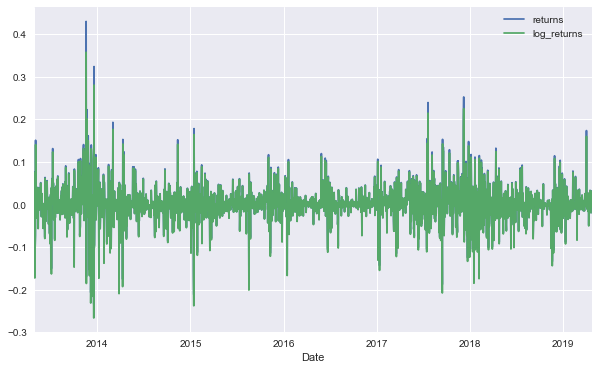

In [20]:
df.loc[:, ['returns', 'log_returns']].plot(figsize=(10, 6));

<AxesSubplot:xlabel='Date'>

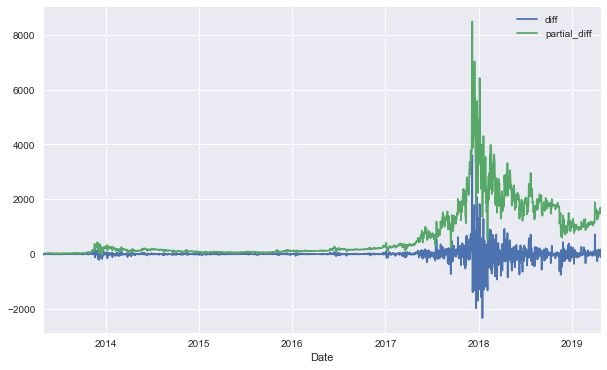

In [21]:
df[["diff", "partial_diff"]].plot(figsize=(10, 6))

#### Shift target features

In [22]:
target_vars = ["returns", "log_returns", "diff", "partial_diff", "returns_class", "close"]

In [23]:
df = df.join(df[target_vars].shift(-1).dropna(), how='right', rsuffix='_target')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2178 entries, 2013-05-07 to 2019-04-23
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   currency              2178 non-null   object  
 1   open                  2178 non-null   float64 
 2   high                  2178 non-null   float64 
 3   low                   2178 non-null   float64 
 4   close                 2178 non-null   float64 
 5   volume                1944 non-null   float64 
 6   market_cap            2178 non-null   float64 
 7   returns               2178 non-null   float64 
 8   diff                  2178 non-null   float64 
 9   partial_diff          2177 non-null   float64 
 10  log_returns           2178 non-null   float64 
 11  returns_class         2178 non-null   category
 12  returns_target        2178 non-null   float64 
 13  log_returns_target    2178 non-null   float64 
 14  diff_target           2178 non-null   

In [25]:
df.returns_class_target = df.returns_class_target.astype(int)

In [26]:
df.head()

,currency,open,high,low,close,volume,market_cap,returns,diff,partial_diff,log_returns,returns_class,returns_target,log_returns_target,diff_target,partial_diff_target,returns_class_target,close_target
Date,,,,,,,,,,,,,,,,,,
2013-05-07,bitcoin,112.25,113.44,97.70,111.50,NaN,1.240594e+09,-0.007124,-0.80,NaN,-0.007149,-1,0.018565,0.018395,2.07,31.946332,1,113.57
2013-05-08,bitcoin,109.60,115.78,109.60,113.57,NaN,1.264049e+09,0.018565,2.07,31.946332,0.018395,1,-0.007925,-0.007956,-0.90,30.753914,-1,112.67
2013-05-09,bitcoin,113.20,113.46,109.26,112.67,NaN,1.254535e+09,-0.007925,-0.90,30.753914,-0.007956,-1,0.040206,0.039419,4.53,35.753313,1,117.20
2013-05-10,bitcoin,112.80,122.00,111.55,117.20,NaN,1.305479e+09,0.040206,4.53,35.753313,0.039419,1,-0.016724,-0.016865,-1.96,32.012793,-1,115.24
2013-05-11,bitcoin,117.70,118.68,113.01,115.24,NaN,1.284207e+09,-0.016724,-1.96,32.012793,-0.016865,-1,-0.002083,-0.002085,-0.24,31.900824,-1,115.00


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2178 entries, 2013-05-07 to 2019-04-23
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   currency              2178 non-null   object  
 1   open                  2178 non-null   float64 
 2   high                  2178 non-null   float64 
 3   low                   2178 non-null   float64 
 4   close                 2178 non-null   float64 
 5   volume                1944 non-null   float64 
 6   market_cap            2178 non-null   float64 
 7   returns               2178 non-null   float64 
 8   diff                  2178 non-null   float64 
 9   partial_diff          2177 non-null   float64 
 10  log_returns           2178 non-null   float64 
 11  returns_class         2178 non-null   category
 12  returns_target        2178 non-null   float64 
 13  log_returns_target    2178 non-null   float64 
 14  diff_target           2178 non-null   

#### Defining number of coins variable

In [28]:
df["number_coins"] = df["market_cap"] / df["close"]

In [29]:
df.head()

,currency,open,high,low,close,volume,market_cap,returns,diff,partial_diff,log_returns,returns_class,returns_target,log_returns_target,diff_target,partial_diff_target,returns_class_target,close_target,number_coins
Date,,,,,,,,,,,,,,,,,,,
2013-05-07,bitcoin,112.25,113.44,97.70,111.50,NaN,1.240594e+09,-0.007124,-0.80,NaN,-0.007149,-1,0.018565,0.018395,2.07,31.946332,1,113.57,1.112640e+07
2013-05-08,bitcoin,109.60,115.78,109.60,113.57,NaN,1.264049e+09,0.018565,2.07,31.946332,0.018395,1,-0.007925,-0.007956,-0.90,30.753914,-1,112.67,1.113013e+07
2013-05-09,bitcoin,113.20,113.46,109.26,112.67,NaN,1.254535e+09,-0.007925,-0.90,30.753914,-0.007956,-1,0.040206,0.039419,4.53,35.753313,1,117.20,1.113460e+07
2013-05-10,bitcoin,112.80,122.00,111.55,117.20,NaN,1.305479e+09,0.040206,4.53,35.753313,0.039419,1,-0.016724,-0.016865,-1.96,32.012793,-1,115.24,1.113890e+07
2013-05-11,bitcoin,117.70,118.68,113.01,115.24,NaN,1.284207e+09,-0.016724,-1.96,32.012793,-0.016865,-1,-0.002083,-0.002085,-0.24,31.900824,-1,115.00,1.114377e+07


<AxesSubplot:xlabel='Date'>

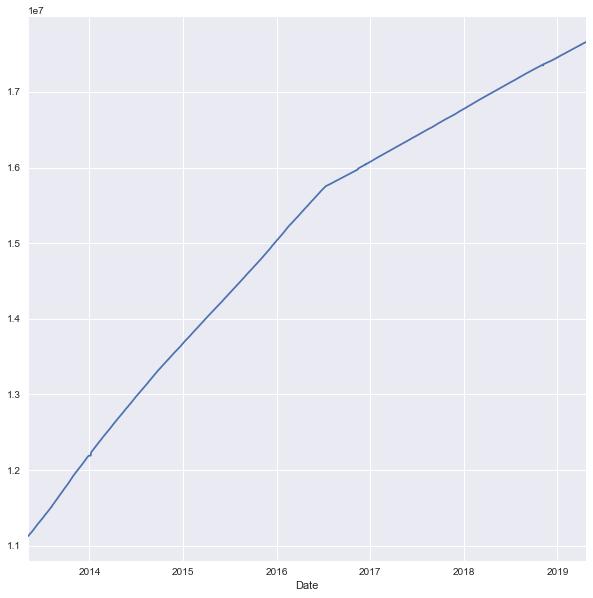

In [30]:
plt.figure(figsize=(10, 10))
df.number_coins.plot()

**Defining date related variables**

In [31]:
df["weekday"] = df.index.day_name()
df["week"] = df.index.isocalendar().week
df["month_name"] = df.index.month_name()
df["month"] = df.index.day
df["month"] = df.month.apply(lambda day: "beginning" if day <= 10 else "end" if day > 20 else "middle")

weekdays = CategoricalDtype(categories=list(calendar.day_name), ordered=True)
df.weekday = df.weekday.astype(weekdays)

week = CategoricalDtype(categories=[n for n in range(1, 54)], ordered=True)
df.week = df.week.astype(week)

months = CategoricalDtype(categories=list(calendar.month_name)[1:], ordered=True)
df.month_name = df.month_name.astype(months)

In [32]:
df.head()

,currency,open,high,low,close,volume,market_cap,returns,diff,partial_diff,...,log_returns_target,diff_target,partial_diff_target,returns_class_target,close_target,number_coins,weekday,week,month_name,month
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-07,bitcoin,112.25,113.44,97.70,111.50,NaN,1.240594e+09,-0.007124,-0.80,NaN,...,0.018395,2.07,31.946332,1,113.57,1.112640e+07,Tuesday,19,May,beginning
2013-05-08,bitcoin,109.60,115.78,109.60,113.57,NaN,1.264049e+09,0.018565,2.07,31.946332,...,-0.007956,-0.90,30.753914,-1,112.67,1.113013e+07,Wednesday,19,May,beginning
2013-05-09,bitcoin,113.20,113.46,109.26,112.67,NaN,1.254535e+09,-0.007925,-0.90,30.753914,...,0.039419,4.53,35.753313,1,117.20,1.113460e+07,Thursday,19,May,beginning
2013-05-10,bitcoin,112.80,122.00,111.55,117.20,NaN,1.305479e+09,0.040206,4.53,35.753313,...,-0.016865,-1.96,32.012793,-1,115.24,1.113890e+07,Friday,19,May,beginning
2013-05-11,bitcoin,117.70,118.68,113.01,115.24,NaN,1.284207e+09,-0.016724,-1.96,32.012793,...,-0.002085,-0.24,31.900824,-1,115.00,1.114377e+07,Saturday,19,May,middle


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2178 entries, 2013-05-07 to 2019-04-23
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   currency              2178 non-null   object  
 1   open                  2178 non-null   float64 
 2   high                  2178 non-null   float64 
 3   low                   2178 non-null   float64 
 4   close                 2178 non-null   float64 
 5   volume                1944 non-null   float64 
 6   market_cap            2178 non-null   float64 
 7   returns               2178 non-null   float64 
 8   diff                  2178 non-null   float64 
 9   partial_diff          2177 non-null   float64 
 10  log_returns           2178 non-null   float64 
 11  returns_class         2178 non-null   category
 12  returns_target        2178 non-null   float64 
 13  log_returns_target    2178 non-null   float64 
 14  diff_target           2178 non-null   

**Defining volatility**

In [34]:
df["range"] = (df["high"] - df["low"]) / df["low"]

In [35]:
df.head(10)

,currency,open,high,low,close,volume,market_cap,returns,diff,partial_diff,...,diff_target,partial_diff_target,returns_class_target,close_target,number_coins,weekday,week,month_name,month,range
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-07,bitcoin,112.25,113.44,97.70,111.50,NaN,1.240594e+09,-0.007124,-0.80,NaN,...,2.07,31.946332,1,113.57,1.112640e+07,Tuesday,19,May,beginning,0.161105
2013-05-08,bitcoin,109.60,115.78,109.60,113.57,NaN,1.264049e+09,0.018565,2.07,31.946332,...,-0.90,30.753914,-1,112.67,1.113013e+07,Wednesday,19,May,beginning,0.056387
2013-05-09,bitcoin,113.20,113.46,109.26,112.67,NaN,1.254535e+09,-0.007925,-0.90,30.753914,...,4.53,35.753313,1,117.20,1.113460e+07,Thursday,19,May,beginning,0.038440
2013-05-10,bitcoin,112.80,122.00,111.55,117.20,NaN,1.305479e+09,0.040206,4.53,35.753313,...,-1.96,32.012793,-1,115.24,1.113890e+07,Friday,19,May,beginning,0.093680
2013-05-11,bitcoin,117.70,118.68,113.01,115.24,NaN,1.284207e+09,-0.016724,-1.96,32.012793,...,-0.24,31.900824,-1,115.00,1.114377e+07,Saturday,19,May,middle,0.050173
2013-05-12,bitcoin,115.64,117.45,113.43,115.00,NaN,1.281983e+09,-0.002083,-0.24,31.900824,...,2.98,34.741777,1,117.98,1.114768e+07,Sunday,19,May,middle,0.035440
2013-05-13,bitcoin,114.82,118.70,114.50,117.98,NaN,1.315710e+09,0.025913,2.98,34.741777,...,-6.48,27.040759,-1,111.50,1.115198e+07,Monday,20,May,middle,0.036681
2013-05-14,bitcoin,117.98,119.80,110.25,111.50,NaN,1.243874e+09,-0.054925,-6.48,27.040759,...,2.72,31.997338,1,114.22,1.115583e+07,Tuesday,20,May,middle,0.086621
2013-05-15,bitcoin,111.40,115.81,103.50,114.22,NaN,1.274624e+09,0.024395,2.72,31.997338,...,4.54,35.996285,1,118.76,1.115938e+07,Wednesday,20,May,middle,0.118937


#### Upper and Lower bands diff

In [36]:
sma = 50
dev = 2

df_sma = df["close"].rolling(sma).mean()
df_std = df["close"].rolling(sma).std()

df["lower_distance"] = df["close"] - (df_sma - df_std * dev)
df["upper_distance"] = (df_sma + df_std * dev) - df["close"]

<AxesSubplot:xlabel='Date'>

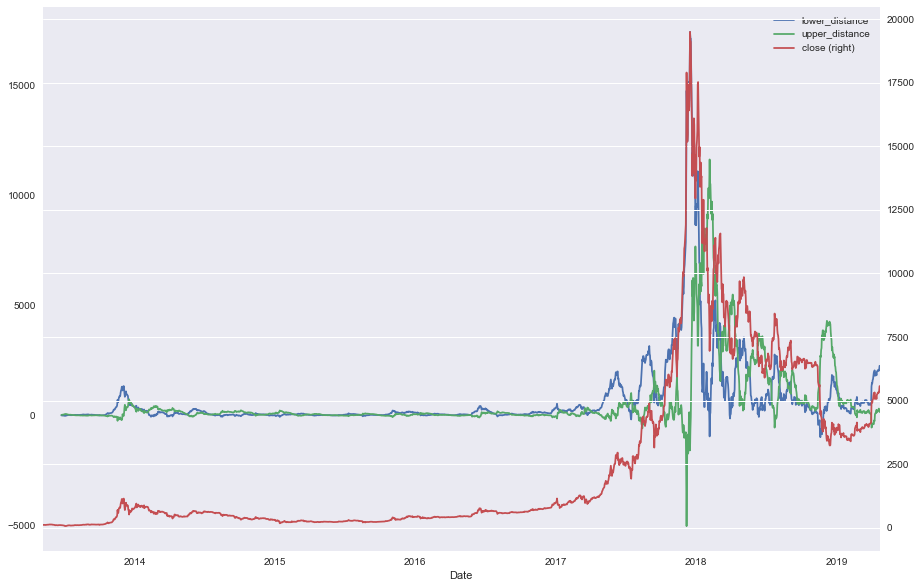

In [37]:
df[["lower_distance", "upper_distance", "close"]].plot(figsize=(15, 10), secondary_y='close')

## Data Exploration

In [38]:
target_variables = ['diff', 'returns', 'log_returns', 'partial_diff']

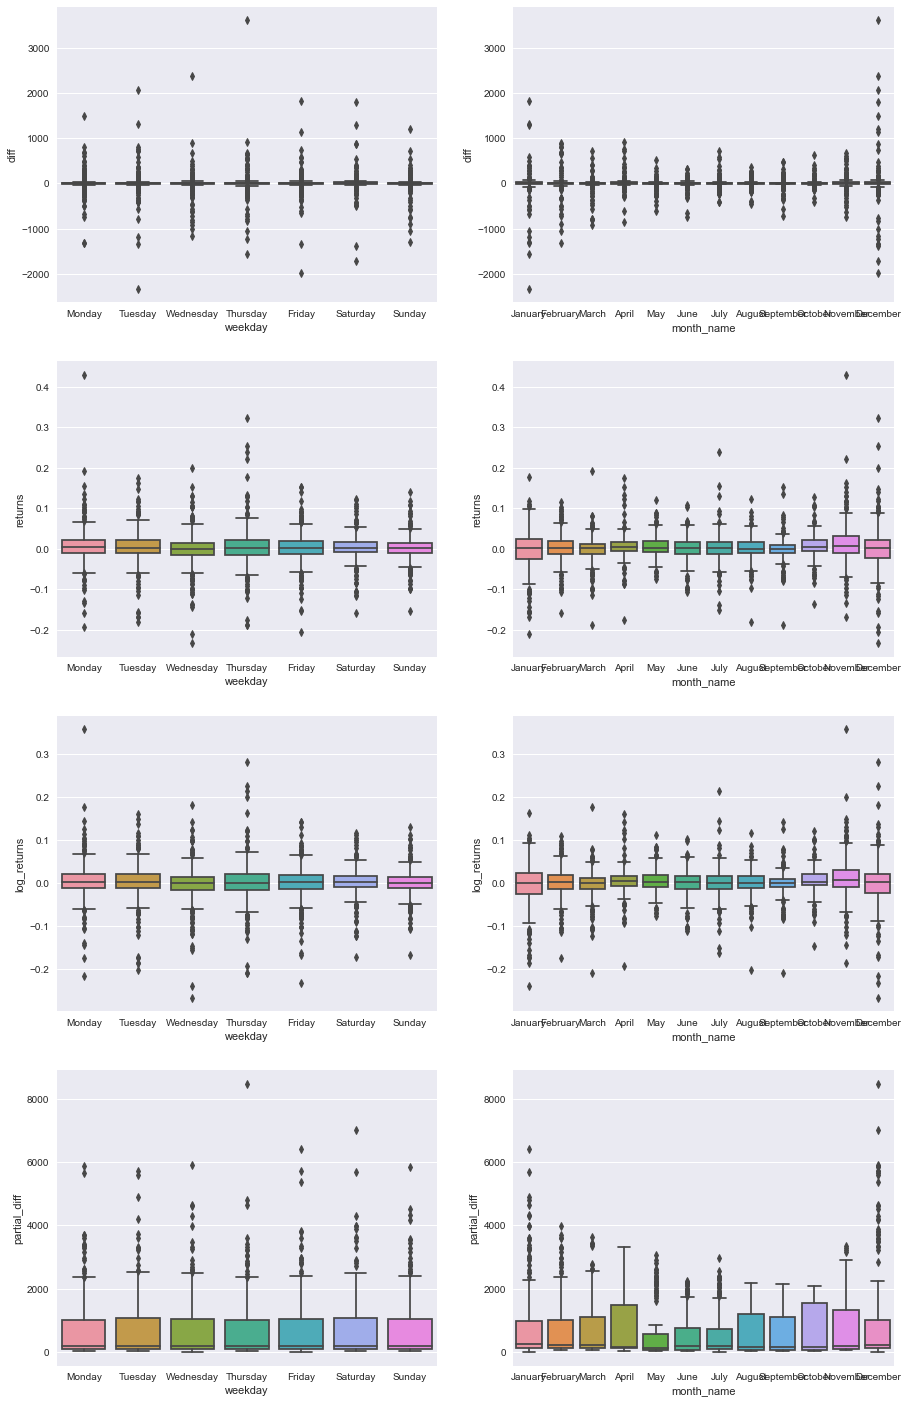

In [39]:
fig, axes = plt.subplots(len(target_variables), 2, figsize=(15, 25))
for i, target in enumerate(target_variables):
    sb.boxplot(ax=axes[i, 0], x="weekday", y=target, data=df);
    sb.boxplot(ax=axes[i, 1], x="month_name", y=target, data=df);

In [40]:
variables = ['returns', 'log_returns', 'diff', 'partial_diff', 'range', 'volume']

In [41]:
def plot_barplots(df, variables):
    number_rows = int(len(variables) / 2)

    fig, axes = plt.subplots(number_rows, 2, figsize=(15, number_rows * 5))
    for i, j in enumerate(list(range(0, len(variables), 2))):
        sb.barplot(ax=axes[i, 0], x=df.index, y=df[variables[j]]);
        sb.barplot(ax=axes[i, 1], x=df.index, y=df[variables[j + 1]]);

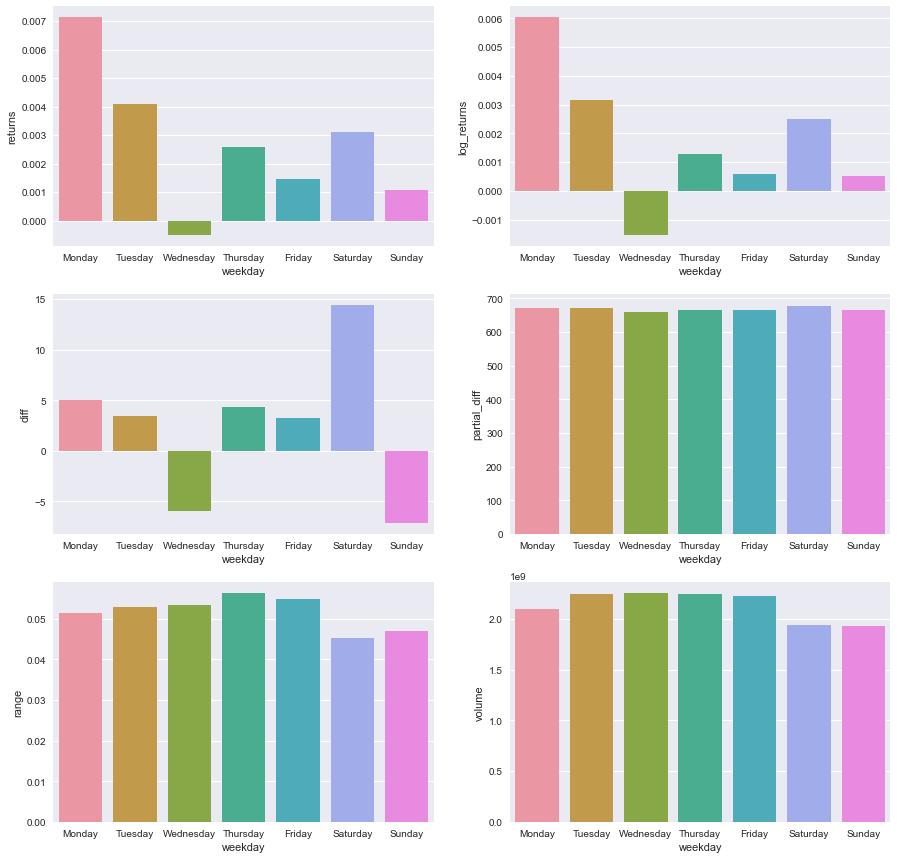

In [42]:
mean_weekday = df.groupby('weekday').mean()[variables]

plot_barplots(mean_weekday, variables)

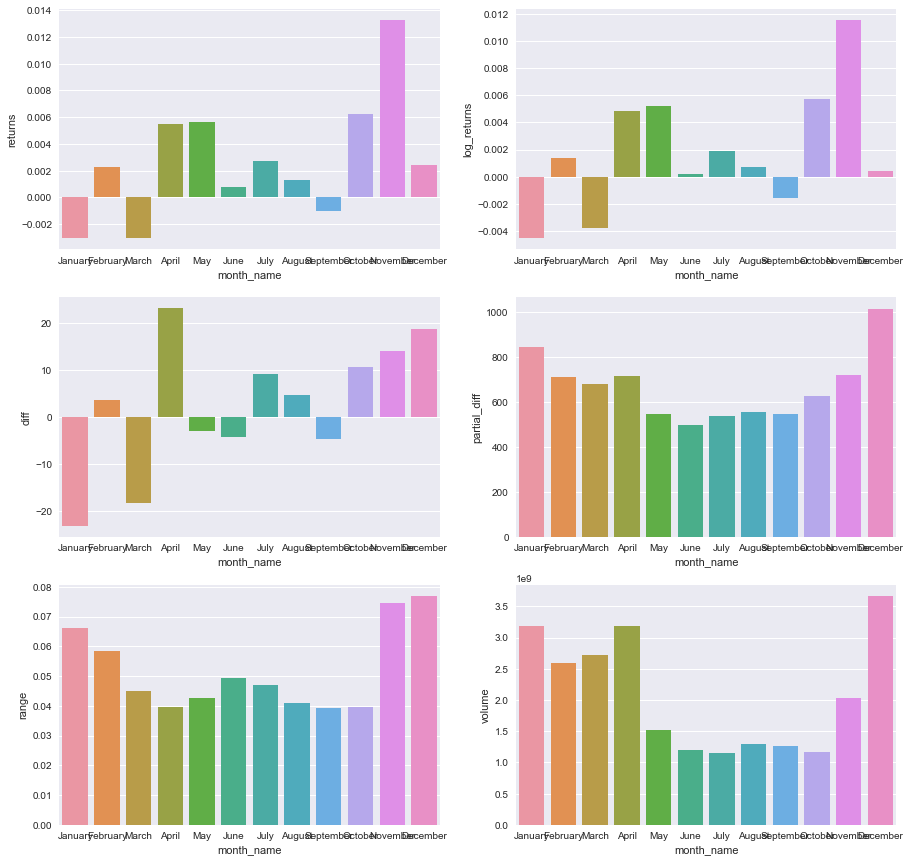

In [43]:
mean_month = df.groupby('month_name').mean()[variables]

plot_barplots(mean_month, variables)

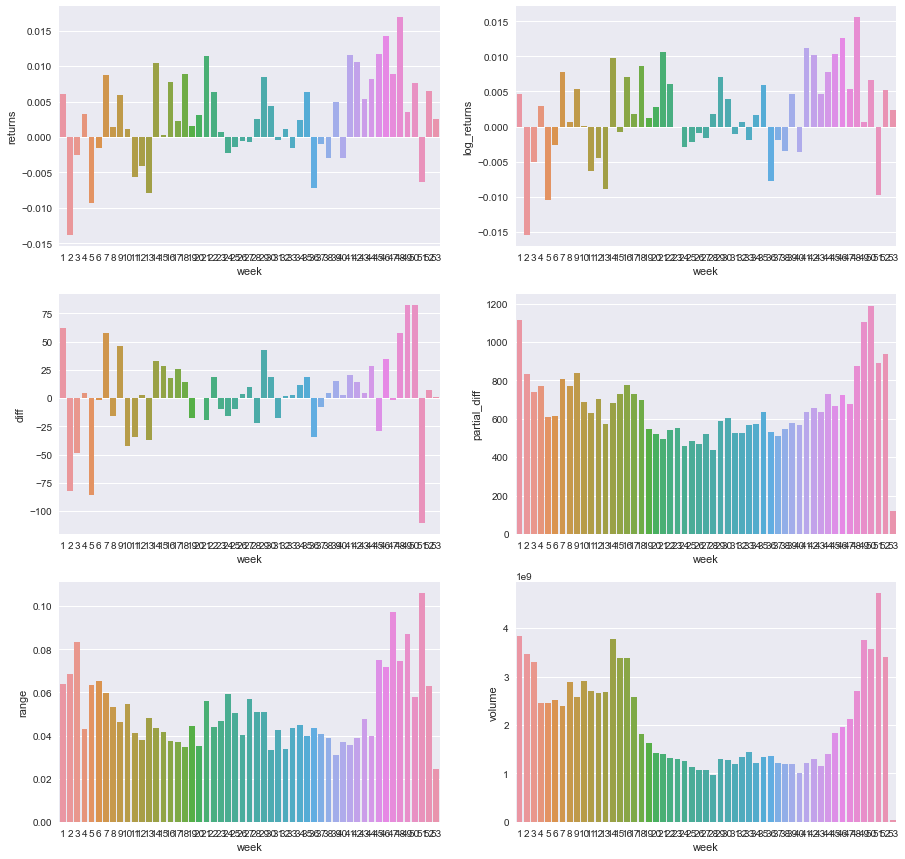

In [44]:
mean_week = df.groupby('week').mean()[variables]

plot_barplots(mean_week, variables)

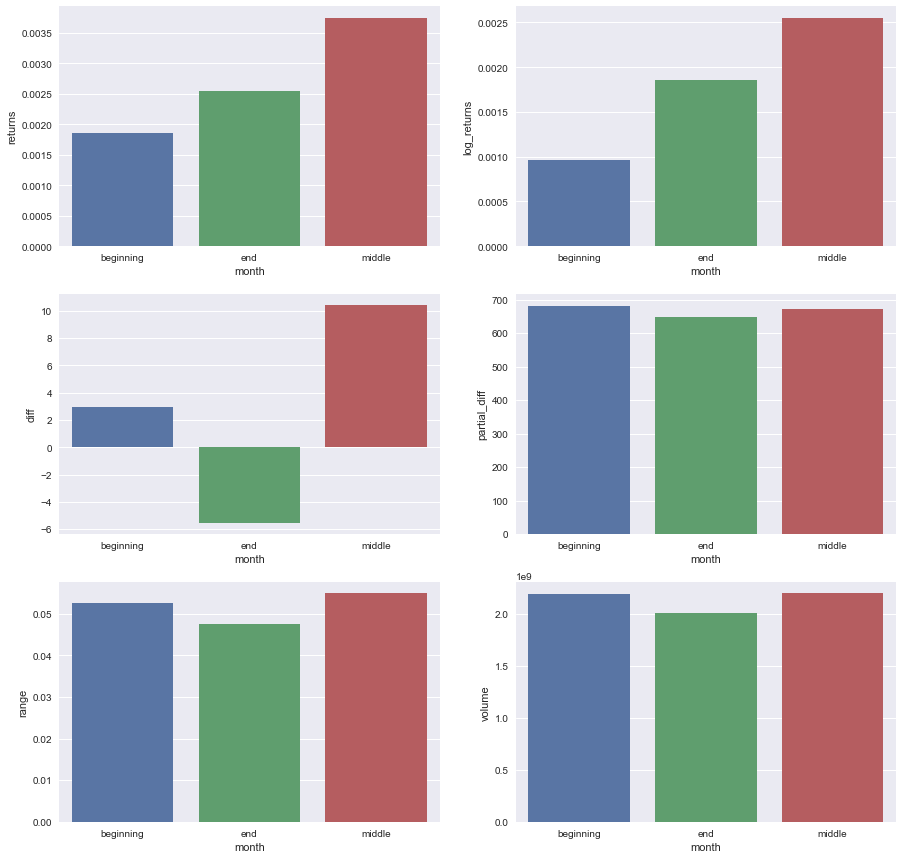

In [45]:
mean_month_loc = df.groupby('month').mean()[variables]

plot_barplots(mean_month_loc, variables)

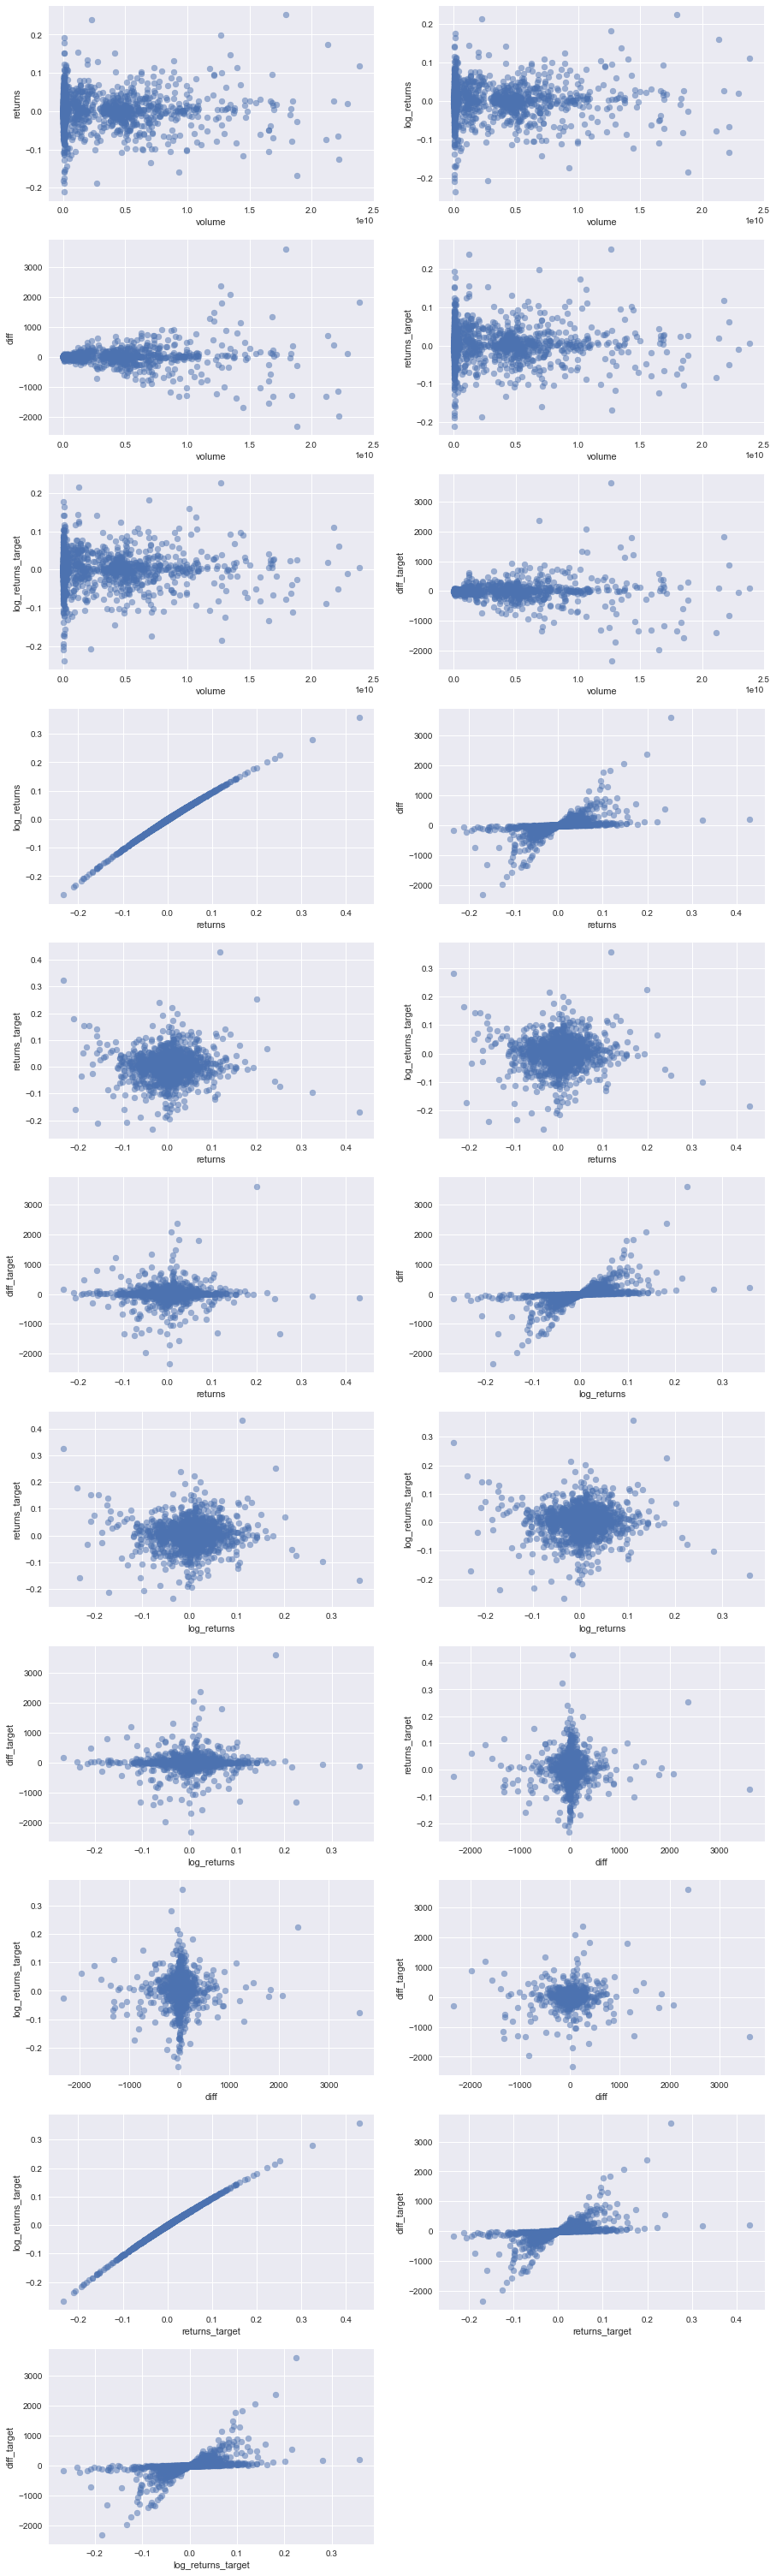

In [46]:
plotting_variables = ["volume", "returns", "log_returns", "diff", "returns_target", "log_returns_target", "diff_target"]

number_rows = int(len(plotting_variables) ** 2 / 2)

plt.figure(figsize=(15, number_rows * 5))
i = 0

pairs_set = {}

for variable_a in plotting_variables:
    
    if variable_a not in pairs_set:
        pairs_set[variable_a] = {}  
    
    for variable_b in plotting_variables:
        
        if variable_b not in pairs_set:
            pairs_set[variable_b] = {}  
        
        if variable_a == variable_b:
            continue
            
        if variable_a in pairs_set[variable_b] or variable_b in pairs_set[variable_a]:
            continue
                
        i += 1
        
        plt.subplot(number_rows, 2, i)
        
        plt.scatter(data=df, x=variable_a, y=variable_b, alpha=0.5)
        plt.xlabel(variable_a);
        plt.ylabel(variable_b);
        
        pairs_set[variable_a][variable_b] = 1
        pairs_set[variable_b][variable_a] = 1

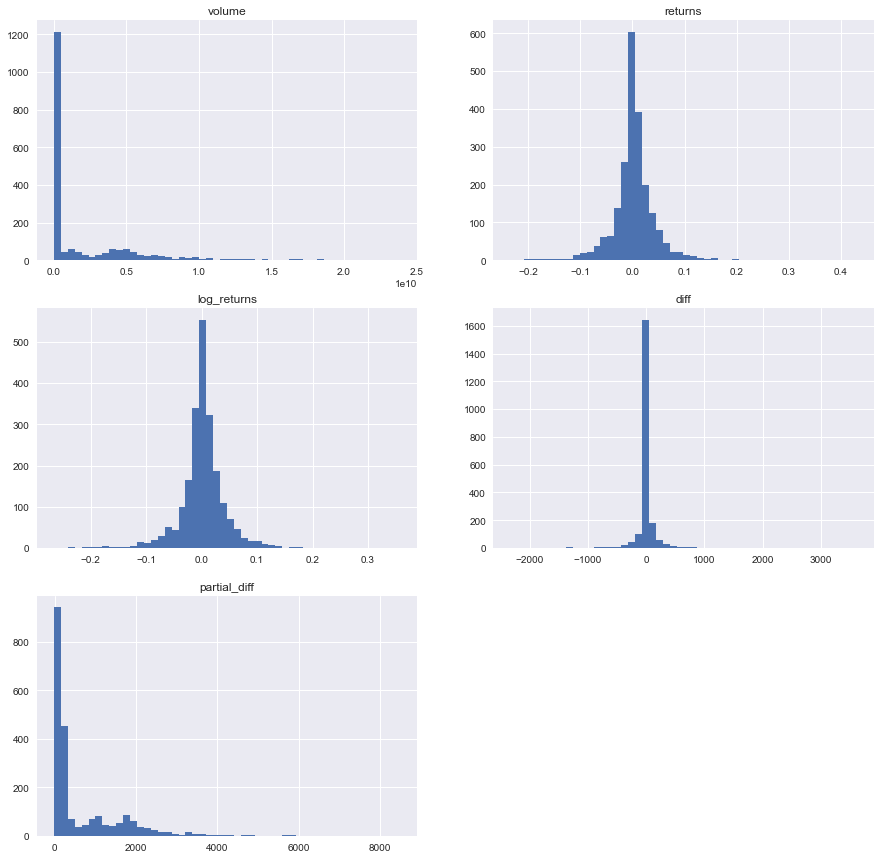

In [47]:
plotting_variables = ["volume", "returns", "log_returns", "diff", "partial_diff"]

number_rows = int(np.ceil(len(plotting_variables) / 2))

plt.figure(figsize=(15, number_rows * 5))
for i, variable in enumerate(plotting_variables):
    
    bin_interval = (df[variable].max() - df[variable].min()) / 50
    bins = np.arange(df[variable].min(), df[variable].max() + bin_interval, bin_interval)
    
    plt.subplot(number_rows, 2, i + 1)
    
    plt.hist(data=df, x=variable, bins=bins)
    plt.title(variable)

#### Autocorrelation plots

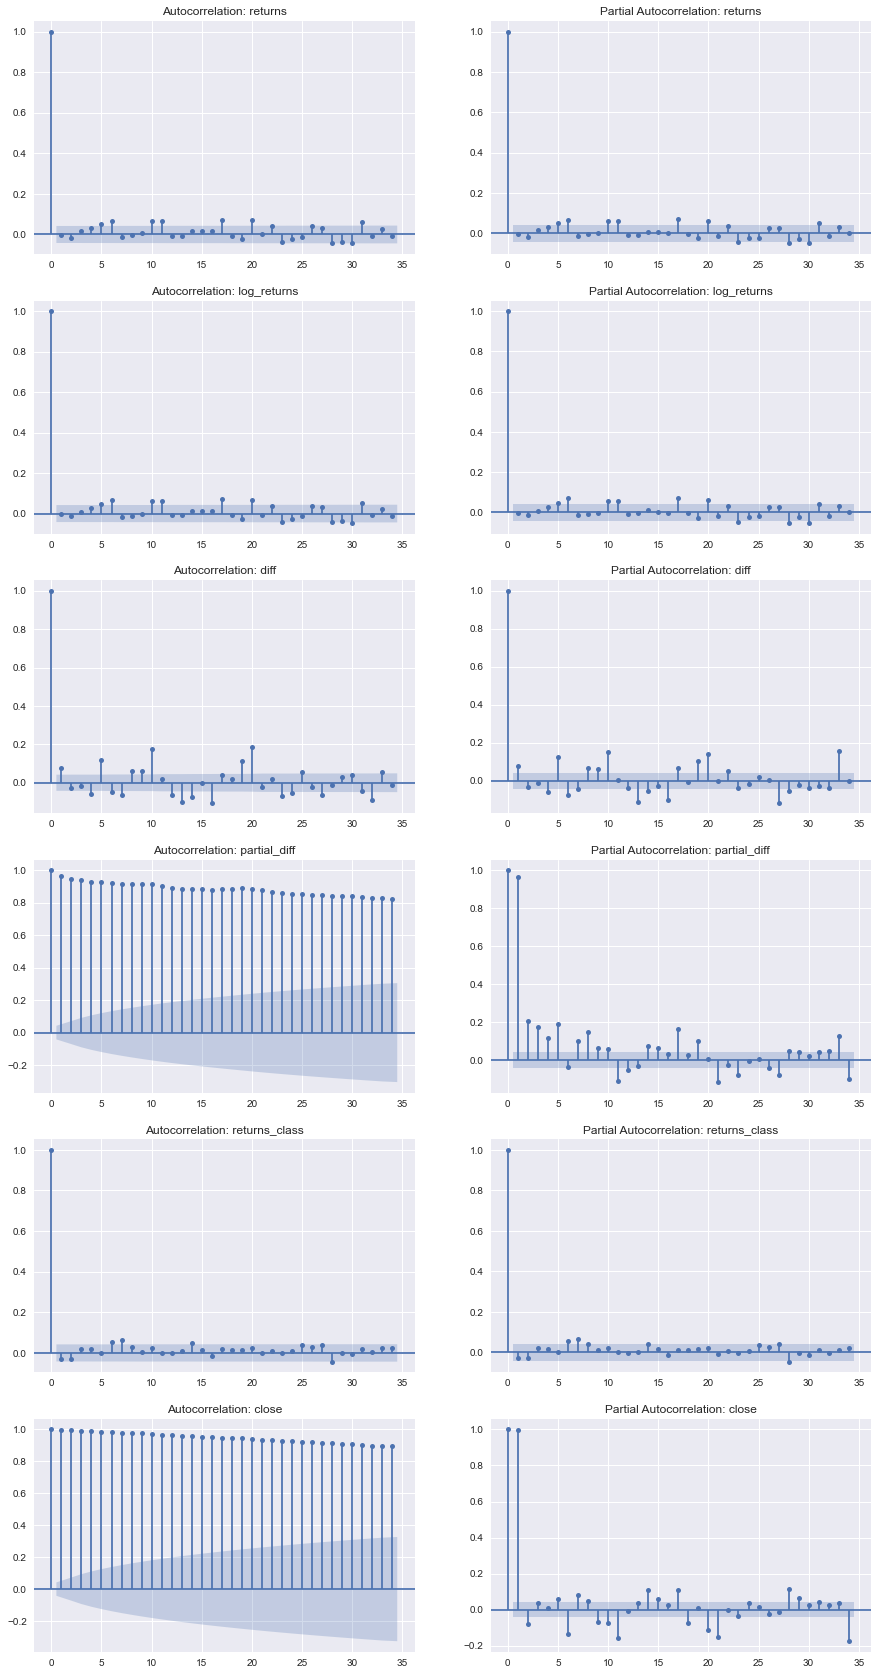

In [48]:
number_rows = len(target_vars)

fig, axes = plt.subplots(number_rows, 2, figsize=(15, number_rows * 5))

for i, target_var in enumerate(target_vars):
            
    plot_acf(df[target_var], ax=axes[i, 0], missing='drop', title=f'Autocorrelation: {target_var}')
    plot_pacf(df[target_var].dropna(), ax=axes[i, 1], title=f'Partial Autocorrelation: {target_var}')

<a id='model_training'></a>
## Model Training

In [49]:
df.head()

,currency,open,high,low,close,volume,market_cap,returns,diff,partial_diff,...,returns_class_target,close_target,number_coins,weekday,week,month_name,month,range,lower_distance,upper_distance
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-07,bitcoin,112.25,113.44,97.70,111.50,NaN,1.240594e+09,-0.007124,-0.80,NaN,...,1,113.57,1.112640e+07,Tuesday,19,May,beginning,0.161105,NaN,NaN
2013-05-08,bitcoin,109.60,115.78,109.60,113.57,NaN,1.264049e+09,0.018565,2.07,31.946332,...,-1,112.67,1.113013e+07,Wednesday,19,May,beginning,0.056387,NaN,NaN
2013-05-09,bitcoin,113.20,113.46,109.26,112.67,NaN,1.254535e+09,-0.007925,-0.90,30.753914,...,1,117.20,1.113460e+07,Thursday,19,May,beginning,0.038440,NaN,NaN
2013-05-10,bitcoin,112.80,122.00,111.55,117.20,NaN,1.305479e+09,0.040206,4.53,35.753313,...,-1,115.24,1.113890e+07,Friday,19,May,beginning,0.093680,NaN,NaN
2013-05-11,bitcoin,117.70,118.68,113.01,115.24,NaN,1.284207e+09,-0.016724,-1.96,32.012793,...,-1,115.00,1.114377e+07,Saturday,19,May,middle,0.050173,NaN,NaN


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2178 entries, 2013-05-07 to 2019-04-23
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   currency              2178 non-null   object  
 1   open                  2178 non-null   float64 
 2   high                  2178 non-null   float64 
 3   low                   2178 non-null   float64 
 4   close                 2178 non-null   float64 
 5   volume                1944 non-null   float64 
 6   market_cap            2178 non-null   float64 
 7   returns               2178 non-null   float64 
 8   diff                  2178 non-null   float64 
 9   partial_diff          2177 non-null   float64 
 10  log_returns           2178 non-null   float64 
 11  returns_class         2178 non-null   category
 12  returns_target        2178 non-null   float64 
 13  log_returns_target    2178 non-null   float64 
 14  diff_target           2178 non-null   

### Strategy 1: Lag Features

#### Create lag features

In [51]:
def get_lag_model_df(df, nr_lags, num_lagged_features, cat_lagged_features, num_features, cat_features, model_target):
    
    lagged_features = [*num_lagged_features, *cat_lagged_features]
    other_features = [*num_features, *cat_features]

    model_features = [*lagged_features, *other_features]
    
    df_model = series_to_supervised(df[lagged_features], nr_lags, 1).join(df[[*other_features, model_target]], how='left')
    df_model.dropna(axis=0, inplace=True)
    
    categorical_features = list(df_model.dtypes[(df_model.dtypes != 'int64') & (df_model.dtypes != 'float64')].index)
    numerical_features = [col for col in df_model.columns if col not in [*categorical_features, model_target]]
    
    return df_model, numerical_features, categorical_features

**Regression: 1 feature model: log_returns**

In [52]:
num_lagged_features = ['log_returns']
cat_lagged_features = []

num_features = []
cat_features = []

model_target = 'log_returns_target'

In [53]:
df_model, numerical_features, categorical_features = get_lag_model_df(
    df, 5, num_lagged_features, cat_lagged_features, num_features, cat_features, model_target
)

	building model...
	fitting data...
	evaluating model...
		R2 score: -0.06909184160437931
		Mean absolute error: 0.025196484330334144
		Mean squared error: 0.0013038157225132895


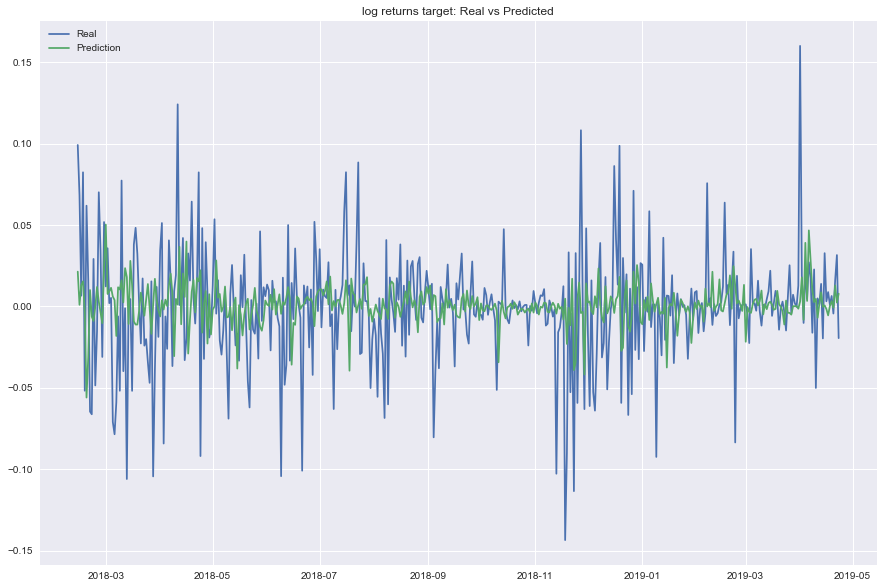

In [54]:
pipeline, X_train, X_test, y_train, y_test = train_model(df_model, 'GradientBoostingRegressor', numerical_features, categorical_features, model_target)

In [55]:
y_pred = pipeline.predict(X_test)

In [56]:
hits = np.sign(y_test * y_pred).value_counts()
hits

-1.0    221
 1.0    214
Name: log_returns_target, dtype: int64

In [57]:
hits[1.0] / sum(hits)

0.49195402298850577

**Regression: More complex model - log_returns**

In [58]:
num_lagged_features = ['log_returns', 'range', 'open', 'close']
cat_lagged_features = []

num_features = []
cat_features = ['week', 'weekday', 'month_name', 'month']

model_target = 'log_returns_target'

In [59]:
df_model, numerical_features, categorical_features = get_lag_model_df(
    df, 10, num_lagged_features, cat_lagged_features, num_features, cat_features, model_target
)

	building model...
	fitting data...
	evaluating model...
		R2 score: -0.15807505159716273
		Mean absolute error: 0.026431075311431542
		Mean squared error: 0.001388736100417864


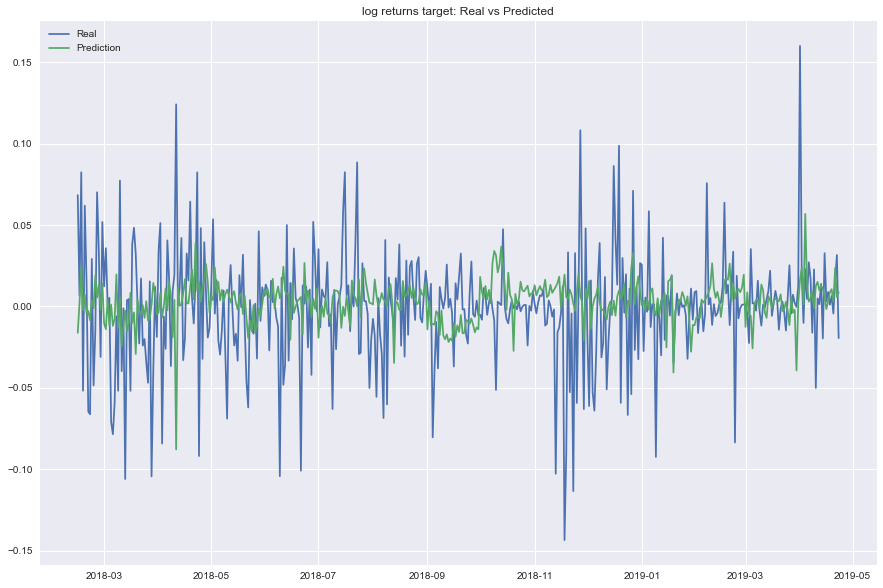

In [60]:
pipeline, X_train, X_test, y_train, y_test = train_model(df_model, 'GradientBoostingRegressor', numerical_features, categorical_features, model_target)

In [61]:
X_test["pred"] = pipeline.predict(X_test)

<ipython-input-61-5c980791a5ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pred"] = pipeline.predict(X_test)


In [62]:
X_test

,log_returns_(t-10),range_(t-10),open_(t-10),close_(t-10),log_returns_(t-9),range_(t-9),open_(t-9),close_(t-9),log_returns_(t-8),range_(t-8),...,log_returns,range,open,close,week,weekday,month_name,month,log_returns_target,pred
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-14,-0.102991,0.162323,9175.70,8277.01,-0.173982,0.238010,8270.54,6955.27,0.108709,0.298010,...,0.099161,0.106817,8599.92,9494.63,7,Wednesday,February,middle,0.068362,-0.016220
2018-02-15,-0.173982,0.238010,8270.54,6955.27,0.108709,0.298010,7051.75,7754.00,-0.017262,0.175813,...,0.068362,0.089321,9488.32,10166.40,7,Thursday,February,middle,0.006618,0.002064
2018-02-16,0.108709,0.298010,7051.75,7754.00,-0.017262,0.175813,7755.49,7621.30,0.081154,0.120572,...,0.006618,0.050818,10135.70,10233.90,7,Friday,February,middle,0.082383,0.024564
2018-02-17,-0.017262,0.175813,7755.49,7621.30,0.081154,0.120572,7637.86,8265.59,0.055463,0.108091,...,0.082383,0.097553,10207.50,11112.70,7,Saturday,February,middle,-0.051792,-0.002492
2018-02-18,0.081154,0.120572,7637.86,8265.59,0.055463,0.108091,8271.84,8736.98,-0.013259,0.099703,...,-0.051792,0.099148,11123.40,10551.80,7,Sunday,February,middle,0.061874,0.007373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-19,-0.016163,0.023706,5289.92,5204.96,0.022716,0.043954,5204.11,5324.55,-0.050075,0.067154,...,0.001022,0.019746,5298.15,5303.81,16,Friday,April,middle,0.006405,0.010589
2019-04-20,0.022716,0.043954,5204.11,5324.55,-0.050075,0.067154,5325.08,5064.49,0.004934,0.029747,...,0.006405,0.011822,5304.16,5337.89,16,Saturday,April,middle,-0.004386,0.002926
2019-04-21,-0.050075,0.067154,5325.08,5064.49,0.004934,0.029747,5061.20,5089.54,0.001384,0.012947,...,-0.004386,0.019514,5335.88,5314.53,16,Sunday,April,end,0.015838,0.023640


In [63]:
hits = np.sign(y_test * X_test.pred).value_counts()
hits

 1.0    228
-1.0    206
dtype: int64

In [64]:
hits[1.0] / sum(hits)

0.5253456221198156

**Classification: 1 feature model - log_returns**

In [65]:
num_lagged_features = ['returns_class', 'log_returns']
cat_lagged_features = []

num_features = []
cat_features = []

model_target = 'returns_class_target'

df_model, numerical_features, categorical_features = get_lag_model_df(
    df, 10, num_lagged_features, cat_lagged_features, num_features, cat_features, model_target
)

	building model...
	fitting data...
	evaluating model...
		F1 score: 0.6497461928934011
		Recall: 0.8275862068965517
		Precision: 0.5348189415041783


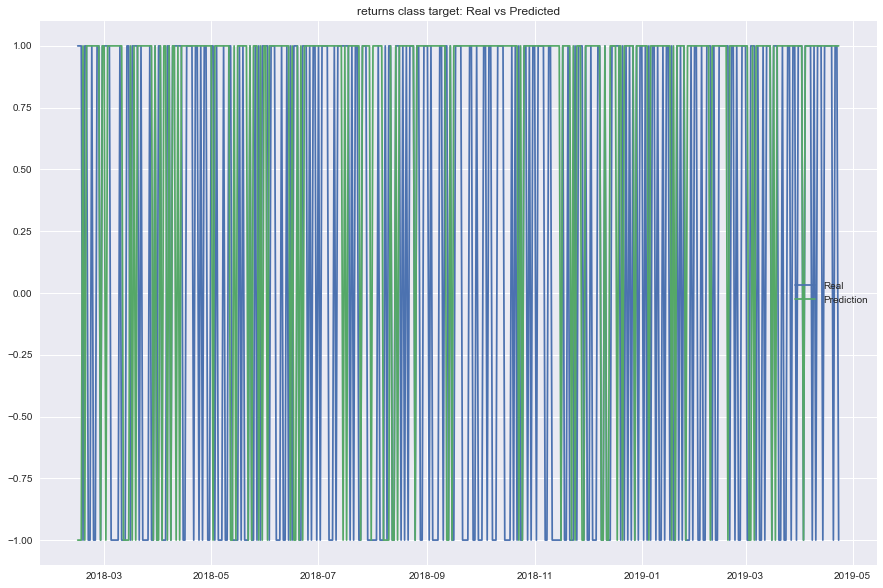

In [66]:
pipeline, X_train, X_test, y_train, y_test = train_model(df_model, 'GradientBoostingClassifier', numerical_features, categorical_features, model_target)

In [67]:
X_test["pred"] = pipeline.predict(X_test)

<ipython-input-67-5c980791a5ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pred"] = pipeline.predict(X_test)


In [68]:
X_test

,returns_class_(t-10),log_returns_(t-10),returns_class_(t-9),log_returns_(t-9),returns_class_(t-8),log_returns_(t-8),returns_class_(t-7),log_returns_(t-7),returns_class_(t-6),log_returns_(t-6),...,returns_class_(t-3),log_returns_(t-3),returns_class_(t-2),log_returns_(t-2),returns_class_(t-1),log_returns_(t-1),returns_class,log_returns,returns_class_target,pred
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-14,-1,-0.102991,-1,-0.173982,1,0.108709,-1,-0.017262,1,0.081154,...,-1,-0.058748,1,0.093475,-1,-0.037467,1,0.099161,1,-1
2018-02-15,-1,-0.173982,1,0.108709,-1,-0.017262,1,0.081154,1,0.055463,...,1,0.093475,-1,-0.037467,1,0.099161,1,0.068362,1,-1
2018-02-16,1,0.108709,-1,-0.017262,1,0.081154,1,0.055463,-1,-0.013259,...,-1,-0.037467,1,0.099161,1,0.068362,1,0.006618,1,-1
2018-02-17,-1,-0.017262,1,0.081154,1,0.055463,-1,-0.013259,-1,-0.058748,...,1,0.099161,1,0.068362,1,0.006618,1,0.082383,-1,1
2018-02-18,1,0.081154,1,0.055463,-1,-0.013259,-1,-0.058748,1,0.093475,...,1,0.068362,1,0.006618,1,0.082383,-1,-0.051792,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-19,-1,-0.016163,1,0.022716,-1,-0.050075,1,0.004934,1,0.001384,...,1,0.032703,1,0.003124,1,0.008805,1,0.001022,1,1
2019-04-20,1,0.022716,-1,-0.050075,1,0.004934,1,0.001384,1,0.013860,...,1,0.003124,1,0.008805,1,0.001022,1,0.006405,-1,1
2019-04-21,-1,-0.050075,1,0.004934,1,0.001384,1,0.013860,-1,-0.019661,...,1,0.008805,1,0.001022,1,0.006405,-1,-0.004386,1,1


In [69]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 434 entries, 2018-02-14 to 2019-04-23
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   returns_class_(t-10)  434 non-null    category
 1   log_returns_(t-10)    434 non-null    float64 
 2   returns_class_(t-9)   434 non-null    category
 3   log_returns_(t-9)     434 non-null    float64 
 4   returns_class_(t-8)   434 non-null    category
 5   log_returns_(t-8)     434 non-null    float64 
 6   returns_class_(t-7)   434 non-null    category
 7   log_returns_(t-7)     434 non-null    float64 
 8   returns_class_(t-6)   434 non-null    category
 9   log_returns_(t-6)     434 non-null    float64 
 10  returns_class_(t-5)   434 non-null    category
 11  log_returns_(t-5)     434 non-null    float64 
 12  returns_class_(t-4)   434 non-null    category
 13  log_returns_(t-4)     434 non-null    float64 
 14  returns_class_(t-3)   434 non-null    c

In [70]:
pipeline.score(X_test, y_test)

0.5230414746543779

In [71]:
pipeline.score(X_train, y_train)

0.591118800461361

In [72]:
y_test

Date
2018-02-14    1
2018-02-15    1
2018-02-16    1
2018-02-17   -1
2018-02-18    1
             ..
2019-04-19    1
2019-04-20   -1
2019-04-21    1
2019-04-22    1
2019-04-23   -1
Name: returns_class_target, Length: 434, dtype: int64

In [73]:
hits = np.sign(y_test * X_test.pred).value_counts()
hits

 1    227
-1    207
dtype: int64

In [74]:
hits[1.0] / hits.sum()

0.5230414746543779

In [75]:
confusion_matrix(y_test, X_test.pred)

array([[ 35, 167],
       [ 40, 192]])

**Classification: More complex model - log_returns**

In [76]:
num_lagged_features = ['returns_class', 'log_returns', 'close', 'range']
cat_lagged_features = []

num_features = []
cat_features = ['week', 'weekday', 'month_name', 'month']

model_target = 'returns_class_target'

df_model, numerical_features, categorical_features = get_lag_model_df(
    df, 10, num_lagged_features, cat_lagged_features, num_features, cat_features, model_target
)

	building model...
	fitting data...
	evaluating model...
		F1 score: 0.6842105263157895
		Recall: 0.9525862068965517
		Precision: 0.533816425120773


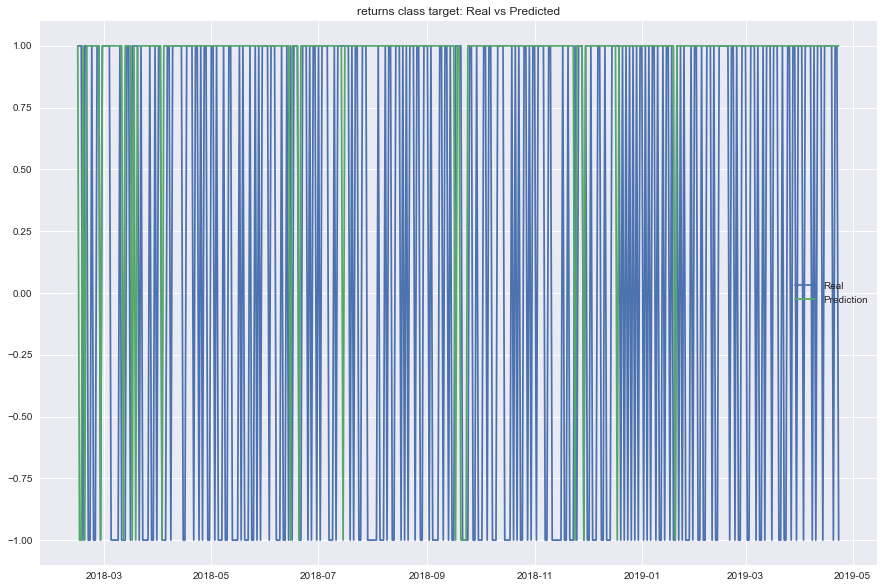

In [77]:
pipeline, X_train, X_test, y_train, y_test = train_model(df_model, 'GradientBoostingClassifier', numerical_features, categorical_features, model_target)

In [78]:
X_test["pred"] = pipeline.predict(X_test)

<ipython-input-78-5c980791a5ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pred"] = pipeline.predict(X_test)


In [79]:
X_test

,returns_class_(t-10),log_returns_(t-10),close_(t-10),range_(t-10),returns_class_(t-9),log_returns_(t-9),close_(t-9),range_(t-9),returns_class_(t-8),log_returns_(t-8),...,returns_class,log_returns,close,range,week,weekday,month_name,month,returns_class_target,pred
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-14,-1,-0.102991,8277.01,0.162323,-1,-0.173982,6955.27,0.238010,1,0.108709,...,1,0.099161,9494.63,0.106817,7,Wednesday,February,middle,1,1
2018-02-15,-1,-0.173982,6955.27,0.238010,1,0.108709,7754.00,0.298010,-1,-0.017262,...,1,0.068362,10166.40,0.089321,7,Thursday,February,middle,1,-1
2018-02-16,1,0.108709,7754.00,0.298010,-1,-0.017262,7621.30,0.175813,1,0.081154,...,1,0.006618,10233.90,0.050818,7,Friday,February,middle,1,-1
2018-02-17,-1,-0.017262,7621.30,0.175813,1,0.081154,8265.59,0.120572,1,0.055463,...,1,0.082383,11112.70,0.097553,7,Saturday,February,middle,-1,1
2018-02-18,1,0.081154,8265.59,0.120572,1,0.055463,8736.98,0.108091,-1,-0.013259,...,-1,-0.051792,10551.80,0.099148,7,Sunday,February,middle,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-19,-1,-0.016163,5204.96,0.023706,1,0.022716,5324.55,0.043954,-1,-0.050075,...,1,0.001022,5303.81,0.019746,16,Friday,April,middle,1,1
2019-04-20,1,0.022716,5324.55,0.043954,-1,-0.050075,5064.49,0.067154,1,0.004934,...,1,0.006405,5337.89,0.011822,16,Saturday,April,middle,-1,1
2019-04-21,-1,-0.050075,5064.49,0.067154,1,0.004934,5089.54,0.029747,1,0.001384,...,-1,-0.004386,5314.53,0.019514,16,Sunday,April,end,1,1


In [80]:
pipeline.score(X_test, y_test)

0.5299539170506913

### Strategy 2: Rolling Window

In [81]:
def rolling_window_df(df, windows, num_features, cat_features, model_target, statistics='mean', mav='sma'):
    
    if not isinstance(windows, list):
        windows = [windows]
        
    if not isinstance(statistics, list):
        statistics = [statistics]
        
    all_features = [*num_features, *cat_features, model_target]
    df_model = df[all_features]
    
    for stat in statistics:
        for window in windows:
            
            if mav == 'sma':
                moving_av = df[num_features].rolling(window=window)
            elif mav == 'ema':
                moving_av = df[num_features].ewm(span=window)
            else:
                raise('Method not supported')
                        
            df_model = df_model.join(
                getattr(moving_av, stat)(), 
                rsuffix=f'_rolling_{mav}_{stat}_{window}'
            )
    
    df_model.dropna(axis=0, inplace=True)
        
    categorical_features = list(df_model.dtypes[(df_model.dtypes != 'int64') & (df_model.dtypes != 'float64')].index)
    numerical_features = [col for col in df_model.columns if col not in [*cat_features, model_target]]
    
    return df_model, categorical_features, numerical_features

**Simple Moving Average**

In [82]:
num_features = ['volume', 'partial_diff', 'range', 'open', 'close']
cat_features = ['week', 'weekday', 'month_name', 'month']

model_target = 'partial_diff_target'

In [83]:
df_model, categorical_features, numerical_features = rolling_window_df(
    df, [2, 5, 7], num_features, cat_features, model_target, statistics=['mean', 'std']
)

In [84]:
df_model

,volume,partial_diff,range,open,close,week,weekday,month_name,month,partial_diff_target,...,volume_rolling_sma_std_5,partial_diff_rolling_sma_std_5,range_rolling_sma_std_5,open_rolling_sma_std_5,close_rolling_sma_std_5,volume_rolling_sma_std_7,partial_diff_rolling_sma_std_7,range_rolling_sma_std_7,open_rolling_sma_std_7,close_rolling_sma_std_7
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,3.848950e+07,252.427302,0.069212,773.44,802.39,1,Thursday,January,beginning,252.672281,...,8.016728e+06,13.537044,0.017146,17.493160,22.545862,1.078118e+07,14.415027,0.022853,16.049427,24.982272
2014-01-03,3.781010e+07,252.672281,0.057064,802.85,818.72,1,Friday,January,beginning,280.979353,...,9.222653e+06,16.251775,0.018384,23.308287,28.802617,8.553468e+06,17.157613,0.016064,25.273255,32.258506
2014-01-04,3.800500e+07,280.979353,0.072149,823.27,859.51,1,Saturday,January,beginning,333.963819,...,9.008140e+06,24.712307,0.021319,29.185389,41.301811,9.317305e+06,22.590901,0.018348,33.724754,41.921976
2014-01-05,7.289850e+07,333.963819,0.114544,858.55,933.53,1,Sunday,January,beginning,316.042664,...,1.858225e+07,39.979086,0.031568,40.855340,62.570063,1.834578e+07,40.457640,0.030959,42.203780,64.906839
2014-01-06,8.556570e+07,316.042664,0.123008,936.05,953.29,2,Monday,January,beginning,142.999469,...,2.297032e+07,36.941687,0.029531,62.556240,67.496750,2.467924e+07,43.594633,0.037385,64.657596,77.359687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-19,1.378024e+10,1498.137941,0.019746,5298.15,5303.81,16,Friday,April,middle,1520.619325,...,8.484644e+08,81.887975,0.011914,89.973898,96.386283,1.230789e+09,74.828917,0.010549,91.475461,94.649390
2019-04-20,1.316965e+10,1520.619325,0.011822,5304.16,5337.89,16,Saturday,April,middle,1474.853491,...,8.393840e+08,17.010638,0.010672,96.618889,41.431859,1.146317e+09,69.541381,0.010714,94.972847,93.360446
2019-04-21,1.373184e+10,1474.853491,0.019514,5335.88,5314.53,16,Sunday,April,end,1558.989935,...,5.420283e+08,19.341109,0.004356,40.741752,31.484274,8.055322e+08,68.992495,0.010574,93.216289,91.547565


	building model...
	fitting data...
	evaluating model...
		R2 score: 0.7716013079643357
		Mean absolute error: 180.96867184929377
		Mean squared error: 61202.375185911915


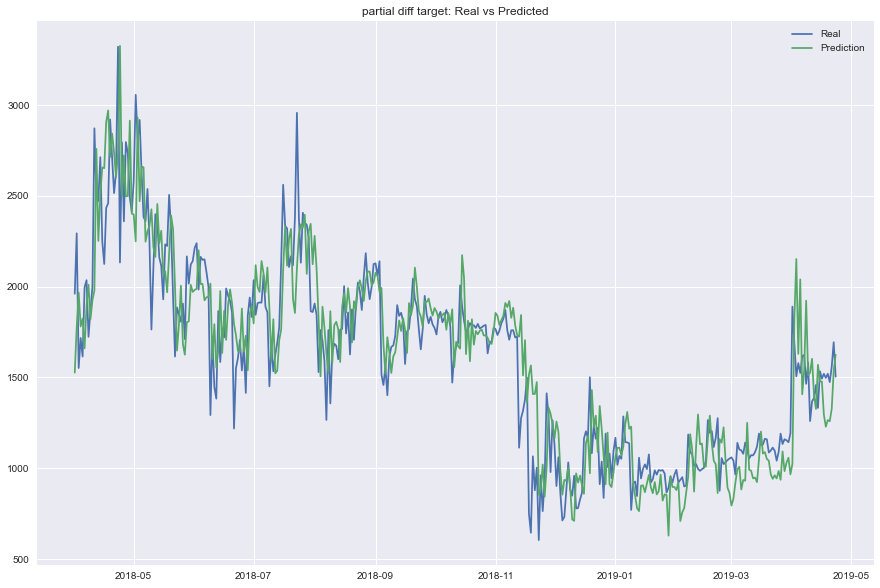

In [85]:
pipeline, X_train, X_test, y_train, y_test = train_model(
    df_model, 'GradientBoostingRegressor', numerical_features, categorical_features, model_target
)

In [86]:
num_features = ['volume', 'diff', 'range', 'open', 'close']
cat_features = ['week', 'weekday', 'month_name', 'month']

model_target = 'returns_class_target'

In [87]:
df_model, categorical_features, numerical_features = rolling_window_df(
    df, [2], num_features, cat_features, model_target, statistics=['mean']
)

In [88]:
df_model

,volume,diff,range,open,close,week,weekday,month_name,month,returns_class_target,volume_rolling_sma_mean_2,diff_rolling_sma_mean_2,range_rolling_sma_mean_2,open_rolling_sma_mean_2,close_rolling_sma_mean_2
Date,,,,,,,,,,,,,,,
2013-12-28,3.250580e+07,-7.24,0.059134,737.98,727.83,52,Saturday,December,end,1,3.968425e+07,-17.075,0.074347,750.630,731.450
2013-12-29,1.901130e+07,17.22,0.047828,728.05,745.05,52,Sunday,December,end,1,2.575855e+07,4.990,0.053481,733.015,736.440
2013-12-30,2.070770e+07,11.08,0.035610,741.35,756.13,1,Monday,December,end,-1,1.985950e+07,14.150,0.041719,734.700,750.590
2013-12-31,2.089730e+07,-2.12,0.030359,760.32,754.01,1,Tuesday,December,end,1,2.080250e+07,4.480,0.032984,750.835,755.070
2014-01-01,2.248940e+07,17.39,0.026994,754.97,771.40,1,Wednesday,January,beginning,1,2.169335e+07,7.635,0.028677,757.645,762.705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-19,1.378024e+10,5.42,0.019746,5298.15,5303.81,16,Friday,April,middle,1,1.351836e+10,25.935,0.016490,5274.815,5301.100
2019-04-20,1.316965e+10,34.08,0.011822,5304.16,5337.89,16,Saturday,April,middle,-1,1.347494e+10,19.750,0.015784,5301.155,5320.850
2019-04-21,1.373184e+10,-23.36,0.019514,5335.88,5314.53,16,Sunday,April,end,1,1.345075e+10,5.360,0.015668,5320.020,5326.210


	building model...
	fitting data...
	evaluating model...
		F1 score: 0.6937394247038917
		Recall: 0.9808612440191388
		Precision: 0.5366492146596858


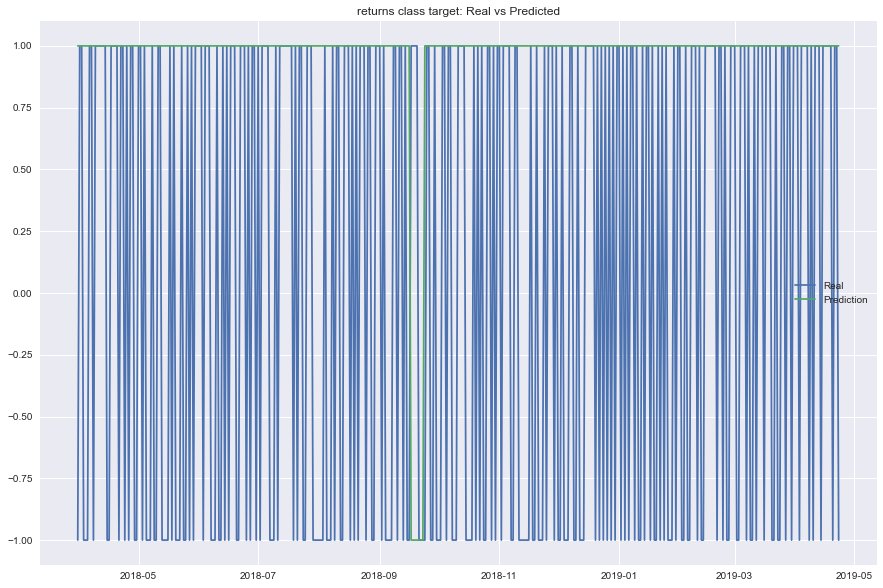

In [89]:
pipeline, X_train, X_test, y_train, y_test = train_model(
    df_model, 'GradientBoostingClassifier', numerical_features, categorical_features, model_target
)

**Exponential Moving Average**

In [90]:
num_features = ['volume', 'partial_diff', 'range', 'open', 'close']
cat_features = ['week', 'weekday', 'month_name', 'month']

model_target = 'partial_diff_target'

In [91]:
df_model, categorical_features, numerical_features = rolling_window_df(
    df, [2, 7], num_features, cat_features, model_target, statistics=['mean'], mav='ema'
)

In [92]:
df_model

,volume,partial_diff,range,open,close,week,weekday,month_name,month,partial_diff_target,volume_rolling_ema_mean_2,partial_diff_rolling_ema_mean_2,range_rolling_ema_mean_2,open_rolling_ema_mean_2,close_rolling_ema_mean_2,volume_rolling_ema_mean_7,partial_diff_rolling_ema_mean_7,range_rolling_ema_mean_7,open_rolling_ema_mean_7,close_rolling_ema_mean_7
Date,,,,,,,,,,,,,,,,,,,,
2013-12-27,4.686270e+07,216.743935,0.089560,763.28,735.07,52,Friday,December,end,207.213132,4.686270e+07,228.816191,0.097029,734.361688,734.423909,4.686270e+07,207.207530,0.123489,691.868690,702.750588
2013-12-28,3.250580e+07,207.213132,0.059134,737.98,727.83,52,Saturday,December,end,224.643749,3.609502e+07,214.414152,0.071765,736.773896,730.027970,3.865876e+07,207.208931,0.107400,703.396518,709.020441
2013-12-29,1.901130e+07,224.643749,0.047828,728.05,745.05,52,Sunday,December,end,226.834099,2.426783e+07,221.233883,0.055807,730.957965,740.042657,3.016256e+07,211.567635,0.092507,709.559888,718.027831
2013-12-30,2.070770e+07,226.834099,0.035610,741.35,756.13,1,Monday,December,end,216.171567,2.186474e+07,224.967360,0.042342,737.885988,750.767552,2.670478e+07,215.384251,0.078283,717.507416,727.553373
2013-12-31,2.089730e+07,216.171567,0.030359,760.32,754.01,1,Tuesday,December,end,230.346831,2.121712e+07,219.103498,0.034353,752.841996,752.929184,2.480118e+07,215.581080,0.066302,728.210562,734.167530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-19,1.378024e+10,1498.137941,0.019746,5298.15,5303.81,16,Friday,April,middle,1520.619325,1.348716e+10,1501.976110,0.018167,5275.570701,5294.476739,1.304742e+10,1477.920413,0.023241,5198.164397,5224.816927
2019-04-20,1.316965e+10,1520.619325,0.011822,5304.16,5337.89,16,Saturday,April,middle,1474.853491,1.327549e+10,1514.404920,0.013937,5294.630234,5323.418913,1.307798e+10,1488.595141,0.020386,5224.663298,5253.085195
2019-04-21,1.373184e+10,1474.853491,0.019514,5335.88,5314.53,16,Sunday,April,end,1558.989935,1.357972e+10,1488.037301,0.017655,5322.130078,5317.492971,1.324145e+10,1485.159728,0.020168,5252.467474,5268.446397


	building model...
	fitting data...
	evaluating model...
		R2 score: 0.7157902970608804
		Mean absolute error: 209.6457975858436
		Mean squared error: 75961.95475517733


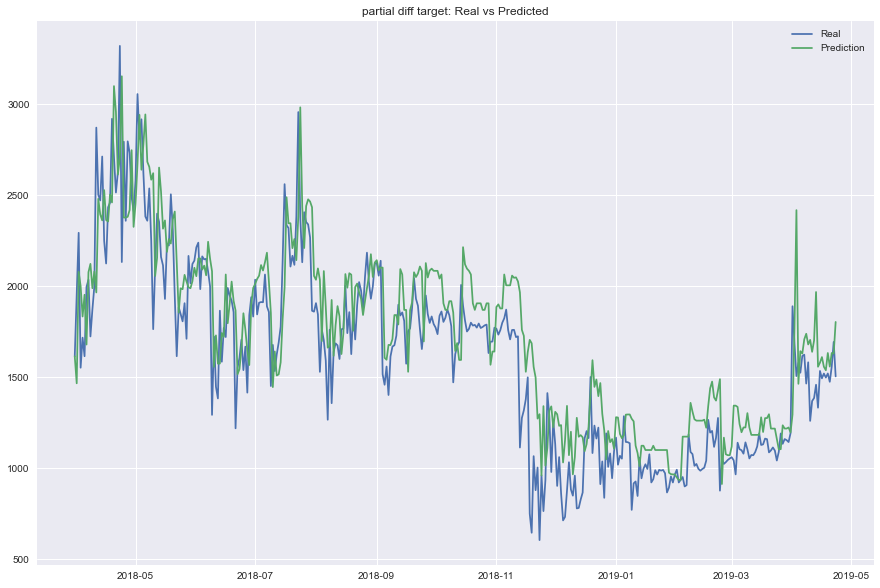

In [93]:
pipeline, X_train, X_test, y_train, y_test = train_model(
    df_model, 'GradientBoostingRegressor', numerical_features, categorical_features, model_target
)

### ML Backtesting Class

In [94]:
class MLBacktester:
    
    def __init__(self, data, lag_features, other_features, target, nr_lags=5, trading_costs=0):
        self.data = data.copy()
        self.nr_lags = nr_lags
        self.tc = trading_costs
        self.lag_features = lag_features
        self.other_features = other_features
        self.target = target
        self.returns_var = 'log_returns_target'
        
        self.get_lag_model_df()
        
    def get_lag_model_df(self):
        
        data = self.data.copy()
        
        model_features = [*self.lag_features, *self.other_features]
        
        other_features = [*self.other_features, self.target]
        if self.returns_var not in [*other_features, *self.lag_features]:
            other_features.append(self.returns_var)
        
        data = series_to_supervised(data[self.lag_features], self.nr_lags, 1).join(data[other_features], how='left')
        data.dropna(axis=0, inplace=True)
    
        cat_features = list(data.dtypes[(data.dtypes != 'int64') & (data.dtypes != 'float64')].index)
        
        excluded_vars = {*categorical_features, self.target, self.returns_var if self.returns_var not in model_features else None}
        
        num_features = [col for col in data.columns if col not in excluded_vars]
        
        data["direction"] = np.sign(data[self.returns_var])
                
        self.data = data
        self.num_features = num_features
        self.cat_features = cat_features
        
    def test_strategy(self, estimator, test_size=0.2, print_results=True, plot_predictions=True):
        
        self.train_model(estimator, test_size=0.2, print_results=True, plot_predictions=True)
        self.assess_strategy()
        
    def assess_strategy(self):
        hits = np.sign(self.y_test * self.X_test.pred).value_counts()
        accuracy = hits[1.0] / hits.sum()
        
        self.X_test["trades"] = self.X_test.pred.diff().fillna(0).abs()
        
        self.X_test["strategy"] = self.X_test.pred * self.X_test[self.returns_var] - self.X_test.trades * self.tc 
        
        self.X_test["creturns"] = self.X_test[self.returns_var].cumsum().apply(np.exp)
        self.X_test["cstrategy"] = self.X_test["strategy"].cumsum().apply(np.exp)

        self.X_test[["creturns", "cstrategy"]].plot(figsize = (15 , 10))

        number_trades = self.X_test.trades.value_counts()[2.0]
        
        print(f"Accuracy: {accuracy}")
        print(f"Numer of trades: {number_trades}")
        
        
    def train_model(self, estimator, test_size=0.2, print_results=True, plot_predictions=True):
        
        pipeline, X_train, X_test, y_train, y_test = train_model(
            self.data, 
            estimator, 
            self.num_features, 
            self.cat_features, 
            self.target, 
            print_results=print_results,
            plot_predictions=plot_predictions,
            test_size=test_size
        )
        
        X_test = X_test.copy()
        X_test["pred"] = np.sign(pipeline.predict(X_test))
        self.data["pred"] = np.sign(pipeline.predict(self.data))
        
        self.pipeline = pipeline
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

	building model...
	fitting data...
	evaluating model...
		F1 score: 0.6703499079189685
		Recall: 0.875
		Precision: 0.5432835820895522
Accuracy: 0.537467700258398
Numer of trades: 74


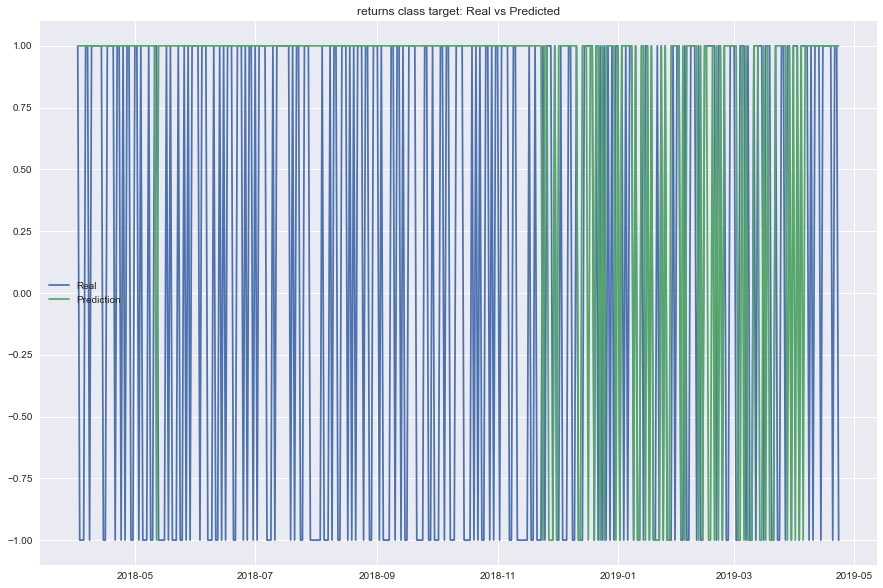

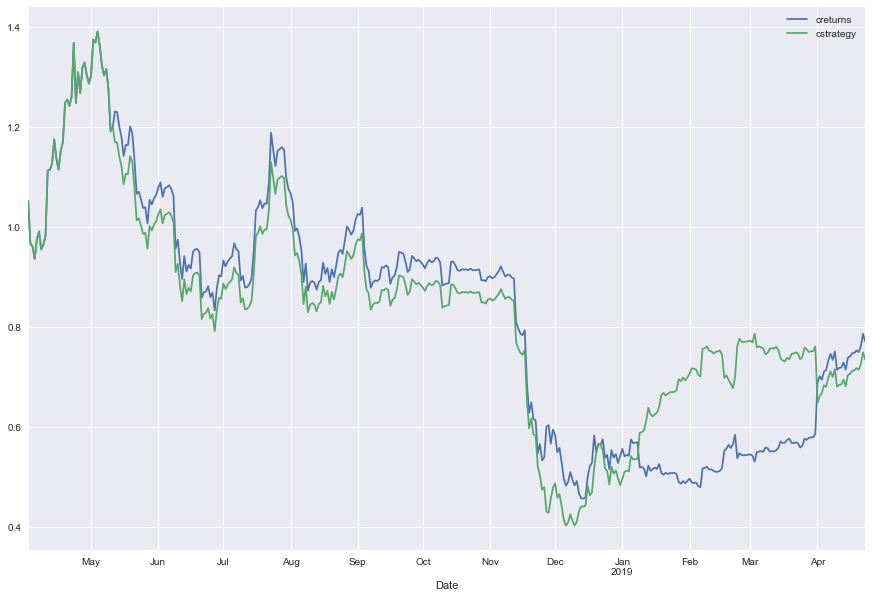

In [95]:
lag_features = ['log_returns', 'high', 'low', 'volume', 'partial_diff']
other_features = ['weekday', 'week', 'month', 'month_name']

target = 'returns_class_target'

ml_tester = MLBacktester(df, lag_features, other_features, target, 10)
ml_tester.test_strategy('RandomForestClassifier')

In [96]:
ml_tester.X_test[["log_returns_target", "direction", "pred", "strategy", "creturns", "cstrategy"]]

,log_returns_target,direction,pred,strategy,creturns,cstrategy
Date,,,,,,
2018-04-02,0.051223,1.0,1,0.051223,1.052558,1.052558
2018-04-03,-0.084225,-1.0,1,-0.084225,0.967537,0.967537
2018-04-04,-0.006201,-1.0,1,-0.006201,0.961556,0.961556
2018-04-05,-0.026050,-1.0,1,-0.026050,0.936831,0.936831
2018-04-06,0.040570,1.0,1,0.040570,0.975619,0.975619
...,...,...,...,...,...,...
2019-04-19,0.006405,1.0,1,0.006405,0.753535,0.718119
2019-04-20,-0.004386,-1.0,1,-0.004386,0.750237,0.714977
2019-04-21,0.015838,1.0,1,0.015838,0.762214,0.726390


	building model...
	fitting data...
	evaluating model...
		F1 score: 0.6679035250463823
		Recall: 0.8653846153846154
		Precision: 0.5438066465256798
Accuracy: 0.537467700258398
Numer of trades: 80


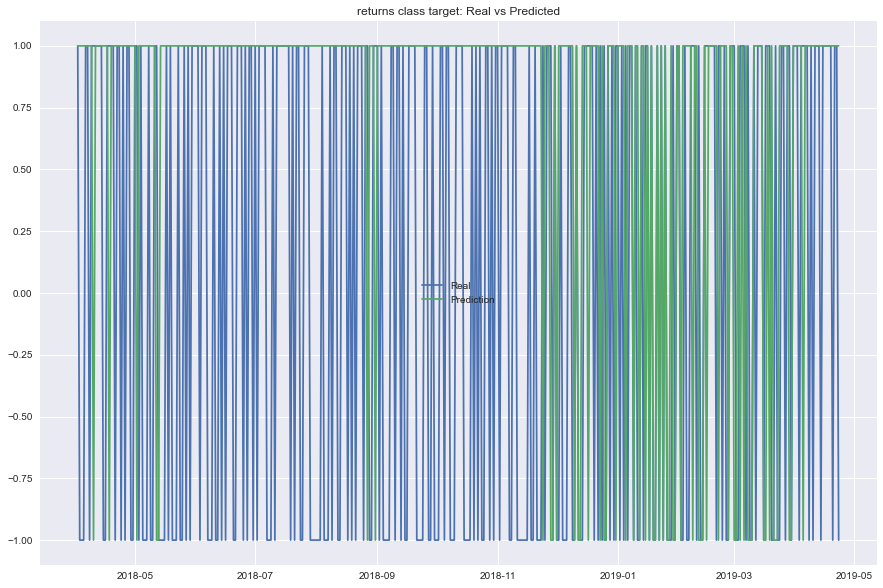

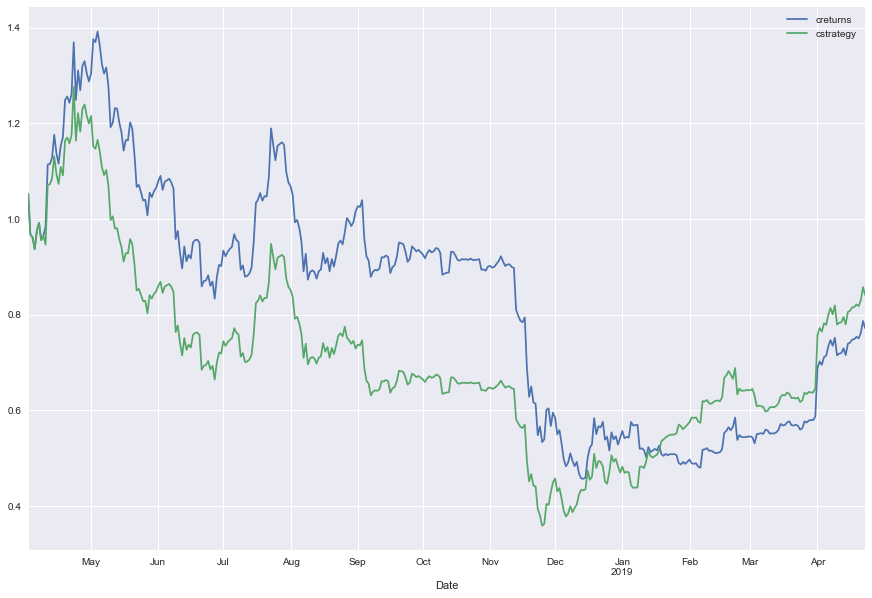

In [113]:
lag_features = ['log_returns', 'high', 'low', 'volume', 'partial_diff', ]
other_features = ['upper_distance', 'weekday', 'week', 'month', 'month_name']

target = 'returns_class_target'

ml_tester = MLBacktester(df, lag_features, other_features, target, 10)
ml_tester.test_strategy('RandomForestClassifier')

In [105]:
results_df = pd.DataFrame(ml_tester.pipeline["estimator"].feature_importances_, index=ml_tester.pipeline["features"].get_feature_names())
results_df = results_df.rename(columns={0: "feature_importance"}).sort_values(by="feature_importance", ascending=False)

In [110]:
pd.set_option('display.max_rows', 150)
results_df

,feature_importance
num_features__log_returns_(t-1),0.020801
num_features__log_returns_(t-9),0.020421
num_features__log_returns,0.019613
num_features__log_returns_(t-5),0.019578
num_features__log_returns_(t-3),0.019561
num_features__log_returns_(t-7),0.019494
num_features__volume_(t-2),0.019241
num_features__log_returns_(t-2),0.018934
num_features__log_returns_(t-8),0.018877
num_features__log_returns_(t-4),0.018194
